In [1]:
import gym
import tensorflow as tf
import numpy as np

In [2]:
env = gym.make('CartPole-v0')

C:\Users\woobi\Anaconda3\lib\site-packages\gym\envs\registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [3]:
class QNetwork:
    def __init__(self,learning_rate=0.01,state_size=4,action_size=2,hidden_size=10,name='QNetwork'):
        with tf.variable_scope(name):
            self.inputs_ = tf.placeholder(tf.float32,[None,state_size], name='inputs')
            self.actions_ = tf.placeholder(tf.int32,[None],name='actions')
            one_hot_actions = tf.one_hot(self.actions_,action_size)
            self.targetQs_ = tf.placeholder(tf.float32,[None],name='target')
            self.fc1 = tf.contrib.layers.fully_connected(self.inputs_,hidden_size)
            self.fc2 = tf.contrib.layers.fully_connected(self.fc1,hidden_size)
            self.output = tf.contrib.layers.fully_connected(self.fc2,action_size,activation_fn=None)
            self.Q = tf.reduce_sum(tf.multiply(self.output,one_hot_actions),axis=1)
            self.loss = tf.reduce_mean(tf.square(self.targetQs_ - self.Q))
            self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

In [4]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
        
    def add(self, experience):
        self.buffer.append(experience)
        
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), size=batch_size, replace=False)
        return [self.buffer[ii] for ii in idx]

## ハイパーパラメーターの定義と初期化

In [5]:
train_episodes = 1000
max_step = 200
gamma = 0.99

explore_start = 1.0
explore_stop = 0.01
decay_rate = 0.0001

hidden_size = 64
learning_rate = 0.0001

memory_size = 10000
batch_size = 20
pretrain_length = batch_size

In [6]:
tf.reset_default_graph()
mainQN = QNetwork(name='main', hidden_size=hidden_size, learning_rate=learning_rate)

## エクスペリエンスメモリーを埋めよう

In [7]:
env.reset()

state,reward,done, _ = env.step(env.action_space.sample())

memory = Memory(max_size=memory_size)

for ii in range(pretrain_length):
    
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    
    if done:
        next_state = np.zeros(state.shape)
        memory.add((state,action,reward,next_state))
        
        env.reset()
        
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        memory.add((state, action, reward, next_state))
        state = next_state

## トレーニング

In [8]:
saver = tf.train.Saver()
rewards_list = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    step = 0
    for ep in range(1, train_episodes):
        total_rewards = 0
        t = 0
        while t < max_step:
            step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate*step)
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                feed = {mainQN.inputs_: state.reshape((1,*state.shape))}
                Qs = sess.run(mainQN.output, feed_dict=feed)
                action = np.argmax(Qs)
                
            next_state, reward, done, _ = env.step(action)
            total_rewards += reward
            
            if done:
                next_state = np.zeros(state.shape)
                t = max_step
                
                # if ep % 100 == 0:
                print('Episode: {}'.format(ep),'Total Reward: {}'.format(total_rewards),
                     'Total Loss: {:.4f}'.format(loss), 'Explore Prob: {:.4f}'.format(explore_p))
                    
                rewards_list.append((ep, total_rewards))
                memory.add((state, action, reward, next_state))
                env.reset()
                state, reward, done, _ = env.step(env.action_space.sample())
            
            else:
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
                
            batch = memory.sample(batch_size)
            # print(batch)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            target_Qs = sess.run(mainQN.output, feed_dict={mainQN.inputs_: next_states})
            episode_ends = (next_states == np.zeros(state[0].shape)).all(axis=1)
            target_Qs[episode_ends] = (0, 0)
            
            targets = rewards + gamma * np.max(target_Qs, axis=1)
            
            loss, _ = sess.run([mainQN.loss, mainQN.opt], 
                              feed_dict={mainQN.inputs_: states,
                                        mainQN.targetQs_: targets,
                                        mainQN.actions_: actions})
            
    saver.save(sess, "checkpoints/cartpole_dqn.ckpt")

Episode: 1 Total Reward: 4.0 Total Loss: 1.0787 Explore Prob: 0.9996
Episode: 2 Total Reward: 14.0 Total Loss: 1.0331 Explore Prob: 0.9982
Episode: 3 Total Reward: 11.0 Total Loss: 1.0269 Explore Prob: 0.9971
Episode: 4 Total Reward: 25.0 Total Loss: 1.0251 Explore Prob: 0.9947
Episode: 5 Total Reward: 25.0 Total Loss: 1.0240 Explore Prob: 0.9922
Episode: 6 Total Reward: 14.0 Total Loss: 1.0658 Explore Prob: 0.9908
Episode: 7 Total Reward: 8.0 Total Loss: 0.9900 Explore Prob: 0.9901
Episode: 8 Total Reward: 34.0 Total Loss: 1.0255 Explore Prob: 0.9867
Episode: 9 Total Reward: 24.0 Total Loss: 1.1099 Explore Prob: 0.9844
Episode: 10 Total Reward: 9.0 Total Loss: 1.0252 Explore Prob: 0.9835
Episode: 11 Total Reward: 21.0 Total Loss: 1.0363 Explore Prob: 0.9815
Episode: 12 Total Reward: 33.0 Total Loss: 1.0448 Explore Prob: 0.9783
Episode: 13 Total Reward: 16.0 Total Loss: 1.0050 Explore Prob: 0.9767
Episode: 14 Total Reward: 21.0 Total Loss: 1.1477 Explore Prob: 0.9747
Episode: 15 Total 

Episode: 119 Total Reward: 12.0 Total Loss: 14.0644 Explore Prob: 0.7881
Episode: 120 Total Reward: 10.0 Total Loss: 102.5085 Explore Prob: 0.7874
Episode: 121 Total Reward: 28.0 Total Loss: 14.7396 Explore Prob: 0.7852
Episode: 122 Total Reward: 8.0 Total Loss: 423.1620 Explore Prob: 0.7846
Episode: 123 Total Reward: 22.0 Total Loss: 10.3842 Explore Prob: 0.7829
Episode: 124 Total Reward: 8.0 Total Loss: 11.8848 Explore Prob: 0.7822
Episode: 125 Total Reward: 11.0 Total Loss: 126.2983 Explore Prob: 0.7814
Episode: 126 Total Reward: 16.0 Total Loss: 12.6969 Explore Prob: 0.7802
Episode: 127 Total Reward: 19.0 Total Loss: 220.8313 Explore Prob: 0.7787
Episode: 128 Total Reward: 11.0 Total Loss: 124.6947 Explore Prob: 0.7779
Episode: 129 Total Reward: 15.0 Total Loss: 216.6199 Explore Prob: 0.7767
Episode: 130 Total Reward: 14.0 Total Loss: 12.5617 Explore Prob: 0.7756
Episode: 131 Total Reward: 41.0 Total Loss: 223.2728 Explore Prob: 0.7725
Episode: 132 Total Reward: 36.0 Total Loss: 97

Episode: 236 Total Reward: 13.0 Total Loss: 21.2703 Explore Prob: 0.6476
Episode: 237 Total Reward: 21.0 Total Loss: 18.4068 Explore Prob: 0.6463
Episode: 238 Total Reward: 21.0 Total Loss: 143.1900 Explore Prob: 0.6449
Episode: 239 Total Reward: 20.0 Total Loss: 105.3319 Explore Prob: 0.6437
Episode: 240 Total Reward: 14.0 Total Loss: 108.9978 Explore Prob: 0.6428
Episode: 241 Total Reward: 11.0 Total Loss: 22.1577 Explore Prob: 0.6421
Episode: 242 Total Reward: 11.0 Total Loss: 49.4792 Explore Prob: 0.6414
Episode: 243 Total Reward: 13.0 Total Loss: 2.0411 Explore Prob: 0.6406
Episode: 244 Total Reward: 15.0 Total Loss: 76.6403 Explore Prob: 0.6396
Episode: 245 Total Reward: 19.0 Total Loss: 49.0023 Explore Prob: 0.6384
Episode: 246 Total Reward: 14.0 Total Loss: 34.8734 Explore Prob: 0.6375
Episode: 247 Total Reward: 9.0 Total Loss: 1.8774 Explore Prob: 0.6370
Episode: 248 Total Reward: 32.0 Total Loss: 1.8606 Explore Prob: 0.6350
Episode: 249 Total Reward: 21.0 Total Loss: 47.4645 

Episode: 350 Total Reward: 46.0 Total Loss: 1.3574 Explore Prob: 0.4176
Episode: 351 Total Reward: 39.0 Total Loss: 61.2739 Explore Prob: 0.4161
Episode: 352 Total Reward: 60.0 Total Loss: 61.8408 Explore Prob: 0.4136
Episode: 353 Total Reward: 32.0 Total Loss: 60.4903 Explore Prob: 0.4123
Episode: 354 Total Reward: 79.0 Total Loss: 1.6013 Explore Prob: 0.4092
Episode: 355 Total Reward: 94.0 Total Loss: 27.6963 Explore Prob: 0.4054
Episode: 356 Total Reward: 43.0 Total Loss: 1.6845 Explore Prob: 0.4037
Episode: 357 Total Reward: 16.0 Total Loss: 20.5671 Explore Prob: 0.4031
Episode: 358 Total Reward: 33.0 Total Loss: 0.9788 Explore Prob: 0.4018
Episode: 359 Total Reward: 71.0 Total Loss: 64.5091 Explore Prob: 0.3990
Episode: 360 Total Reward: 57.0 Total Loss: 2.6629 Explore Prob: 0.3968
Episode: 361 Total Reward: 60.0 Total Loss: 8.8112 Explore Prob: 0.3945
Episode: 362 Total Reward: 105.0 Total Loss: 1.7450 Explore Prob: 0.3905
Episode: 363 Total Reward: 129.0 Total Loss: 26.5165 Expl

Episode: 463 Total Reward: 184.0 Total Loss: 0.5512 Explore Prob: 0.1005
Episode: 464 Total Reward: 199.0 Total Loss: 320.7179 Explore Prob: 0.0987
Episode: 465 Total Reward: 199.0 Total Loss: 0.8036 Explore Prob: 0.0969
Episode: 466 Total Reward: 199.0 Total Loss: 0.7920 Explore Prob: 0.0952
Episode: 467 Total Reward: 199.0 Total Loss: 0.5207 Explore Prob: 0.0935
Episode: 468 Total Reward: 190.0 Total Loss: 0.3979 Explore Prob: 0.0920
Episode: 469 Total Reward: 172.0 Total Loss: 0.9726 Explore Prob: 0.0906
Episode: 470 Total Reward: 199.0 Total Loss: 0.6313 Explore Prob: 0.0890
Episode: 471 Total Reward: 167.0 Total Loss: 0.5515 Explore Prob: 0.0877
Episode: 472 Total Reward: 199.0 Total Loss: 1.0300 Explore Prob: 0.0861
Episode: 473 Total Reward: 164.0 Total Loss: 0.8129 Explore Prob: 0.0849
Episode: 474 Total Reward: 130.0 Total Loss: 0.3415 Explore Prob: 0.0839
Episode: 475 Total Reward: 133.0 Total Loss: 0.4276 Explore Prob: 0.0830
Episode: 476 Total Reward: 176.0 Total Loss: 0.44

Episode: 576 Total Reward: 199.0 Total Loss: 0.1770 Explore Prob: 0.0235
Episode: 577 Total Reward: 199.0 Total Loss: 0.3957 Explore Prob: 0.0232
Episode: 578 Total Reward: 104.0 Total Loss: 0.3053 Explore Prob: 0.0231
Episode: 579 Total Reward: 199.0 Total Loss: 0.2728 Explore Prob: 0.0228
Episode: 580 Total Reward: 199.0 Total Loss: 0.2878 Explore Prob: 0.0226
Episode: 581 Total Reward: 199.0 Total Loss: 0.2970 Explore Prob: 0.0223
Episode: 582 Total Reward: 92.0 Total Loss: 0.1785 Explore Prob: 0.0222
Episode: 583 Total Reward: 92.0 Total Loss: 321.9482 Explore Prob: 0.0221
Episode: 584 Total Reward: 199.0 Total Loss: 0.3395 Explore Prob: 0.0219
Episode: 585 Total Reward: 90.0 Total Loss: 0.2601 Explore Prob: 0.0218
Episode: 586 Total Reward: 95.0 Total Loss: 0.3539 Explore Prob: 0.0217
Episode: 587 Total Reward: 49.0 Total Loss: 0.5571 Explore Prob: 0.0216
Episode: 588 Total Reward: 22.0 Total Loss: 0.7068 Explore Prob: 0.0216
Episode: 589 Total Reward: 35.0 Total Loss: 0.3893 Expl

Episode: 689 Total Reward: 73.0 Total Loss: 0.4160 Explore Prob: 0.0134
Episode: 690 Total Reward: 59.0 Total Loss: 0.4921 Explore Prob: 0.0133
Episode: 691 Total Reward: 48.0 Total Loss: 0.3243 Explore Prob: 0.0133
Episode: 692 Total Reward: 36.0 Total Loss: 142.6388 Explore Prob: 0.0133
Episode: 693 Total Reward: 66.0 Total Loss: 0.3297 Explore Prob: 0.0133
Episode: 694 Total Reward: 45.0 Total Loss: 0.3911 Explore Prob: 0.0133
Episode: 695 Total Reward: 41.0 Total Loss: 0.8202 Explore Prob: 0.0133
Episode: 696 Total Reward: 40.0 Total Loss: 0.6078 Explore Prob: 0.0133
Episode: 697 Total Reward: 43.0 Total Loss: 0.4498 Explore Prob: 0.0132
Episode: 698 Total Reward: 52.0 Total Loss: 0.1943 Explore Prob: 0.0132
Episode: 699 Total Reward: 64.0 Total Loss: 0.4997 Explore Prob: 0.0132
Episode: 700 Total Reward: 55.0 Total Loss: 0.5355 Explore Prob: 0.0132
Episode: 701 Total Reward: 39.0 Total Loss: 0.6737 Explore Prob: 0.0132
Episode: 702 Total Reward: 54.0 Total Loss: 33.3746 Explore Pr

Episode: 810 Total Reward: 12.0 Total Loss: 6.8883 Explore Prob: 0.0110
Episode: 811 Total Reward: 8.0 Total Loss: 6.6608 Explore Prob: 0.0110
Episode: 812 Total Reward: 8.0 Total Loss: 5.1420 Explore Prob: 0.0110
Episode: 813 Total Reward: 10.0 Total Loss: 5.7172 Explore Prob: 0.0110
Episode: 814 Total Reward: 11.0 Total Loss: 671.0966 Explore Prob: 0.0110
Episode: 815 Total Reward: 10.0 Total Loss: 4.8691 Explore Prob: 0.0110
Episode: 816 Total Reward: 11.0 Total Loss: 390.0079 Explore Prob: 0.0110
Episode: 817 Total Reward: 14.0 Total Loss: 3.2845 Explore Prob: 0.0110
Episode: 818 Total Reward: 9.0 Total Loss: 315.0156 Explore Prob: 0.0110
Episode: 819 Total Reward: 11.0 Total Loss: 2.9457 Explore Prob: 0.0110
Episode: 820 Total Reward: 18.0 Total Loss: 3.2802 Explore Prob: 0.0110
Episode: 821 Total Reward: 17.0 Total Loss: 364.3610 Explore Prob: 0.0110
Episode: 822 Total Reward: 58.0 Total Loss: 4.6632 Explore Prob: 0.0110
Episode: 823 Total Reward: 199.0 Total Loss: 3.7299 Explore

Episode: 923 Total Reward: 199.0 Total Loss: 1.1357 Explore Prob: 0.0103
Episode: 924 Total Reward: 199.0 Total Loss: 0.5346 Explore Prob: 0.0103
Episode: 925 Total Reward: 199.0 Total Loss: 0.4558 Explore Prob: 0.0103
Episode: 926 Total Reward: 199.0 Total Loss: 0.4231 Explore Prob: 0.0103
Episode: 927 Total Reward: 199.0 Total Loss: 0.8585 Explore Prob: 0.0103
Episode: 928 Total Reward: 199.0 Total Loss: 0.5419 Explore Prob: 0.0103
Episode: 929 Total Reward: 199.0 Total Loss: 325.1728 Explore Prob: 0.0103
Episode: 930 Total Reward: 199.0 Total Loss: 0.6071 Explore Prob: 0.0103
Episode: 931 Total Reward: 199.0 Total Loss: 0.5583 Explore Prob: 0.0103
Episode: 932 Total Reward: 199.0 Total Loss: 0.5057 Explore Prob: 0.0103
Episode: 933 Total Reward: 199.0 Total Loss: 0.4394 Explore Prob: 0.0103
Episode: 934 Total Reward: 199.0 Total Loss: 0.2954 Explore Prob: 0.0102
Episode: 935 Total Reward: 199.0 Total Loss: 0.2863 Explore Prob: 0.0102
Episode: 936 Total Reward: 199.0 Total Loss: 0.26

## トレーニングの結果を可視化しよう

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

In [10]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[N:] - cumsum[:-N]) / N

Text(0,0.5,'Total Rewards')

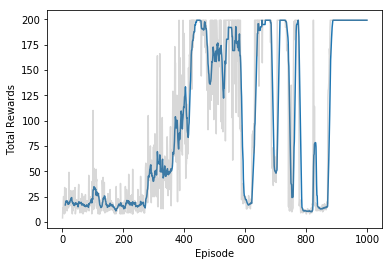

In [11]:
eps, rews = np.array(rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Rewards')

In [12]:
test_episodes = 10
test_max_steps = 400
env.reset()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    for ep in range(1, test_episodes):
        t = 0
        while t < test_max_steps:
            env.render()
            
            feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
            Qs = sess.run(mainQN.output, feed_dict=feed)
            action = np.argmax(Qs)
            
            next_state, reward, done, _ = env.step(action)
            
            if done:
                t = test_max_steps
                env.reset()
                state, reward, done, _ = env.step(env.action_space.sample())
                
            else:
                state = next_state
                t += 1

INFO:tensorflow:Restoring parameters from checkpoints\cartpole_dqn.ckpt
